
# Introduction to Aperture Photometry

This notebook provides a basic introduction to aperture photometry and will demonstrate how to perform aperture photometry in python using the `photutils` package. In order to get the most out of this tutorial, you are encouraged to clone this Jupyter Notebook and experiment with the various code examples on your own. Questions, comments, and suggestions to the author are welcome.

1. [What is Photometry (In General)](#what-is-photometry)
1. [The Point Spread Function](#the-point-spread-function)
1. [What is Aperture Photometry](#what-is-aperture-photometry)
1. [Reading FITS Files](#reading-fits-files)
1. [Coordinates in an Image](#coordinates-in-an-image)
1. [Performing Photometry](#performing-photometry)

## What is Photometry (In General) <a class="anchor" id="what-is-photometry"></a>

Unlike spectra, which classify the energy output of a single object per wavelength, photometric observations are images taken of multiple objects over a range of wavelengths. In many ways photometric images are similar to pictures taken with a black and white camera. At their core they are no more than a collection of pixels, each of which has some numeric value that describes how much light reached that particular point on the camera's sensor.

Photometric images can be taken over a variety of wavelength ranges. These wavelength ranges are referred to as ***bands***, and have standardized letter names. For example, H-band goes from 1.5 to 1.8 micrometers. To observe in a particular band, a telescope observer will use a filter that only lets light within the band pass through the telescope. After light has passed through the filter, the optics in the telescope guide the light onto a CCD sensor.

As mentioned before, this sensor is much the same as those found in a common digital camera, and is broken up into a grid of pixels. When a photon hits a pixel, it releases an electron. By counting the number of electrons in each pixel, we can determine the number of photons that landed at that part of the sensor. This value is typically recorded either in units of total photon counts or as photon counts per second. However, sometime images are converted into other units, like ergs, or nanomaggies. Be careful of the units, don't assume!

It is important to emphasize that in a photometric image, pixels don't represent color values. Instead they represent a number of photons (possibly per second). Color can be added to the image after the fact, but in this notebook, we are only concerned with the numerical data.


## The Point Spread Function

Before talking about aperture photometry, we need to understand the ***point spread function***, also called the **PSF**.

Objects imaged with photometry tend to become "spread out" on a photometric image. This is caused by a combination of influences, including imperfections in the telescope optics, and various effects within the CCD. A sensible question to ask is how much a point source - such as a distant star - is spread out on an image. The answer to this question is the PSF. In fact, an good definition for the point spread function would be *"a function that describes how an imaging system represents a point source"*.

#### Question:
PSF's are typically two dimensional gaussian functions. Remember that the tail ends of a Gaussian never actually reach zero, but instead go on forever. Take a moment to think about how this effects a photometric image?


#### Answer:
Because the tail ends of the PSF go on forever, the light from any object is spread out infinitely across an image. Even though most of the light from a star is focused around a single point in an image, it is impossible to draw a circle around that star on an image and say "this is all of the light from that star". No matter how big we make that circle, there will always be light that fallen outside of it.



## What is Aperture Photometry <a class="anchor" id="what-is-aperture-photometry"></a>

Aperture photometry is a process where we determine the energy output of an object by analyzing photometric images. Pretend you are observing an object with a telescope and imagine a sphere surrounding the object you’re looking at. Also, imagine that this sphere has a radius that is the same as your distance from the object, so that you are on the surface of this sphere. The collection area of your telescope only covers a small portion of the surface area of the sphere. If we assume that the object emits photons evenly in all directions, we can then determine the total photon emissions of the object as

$\ \ \ \ Total\ Photon\ Counts = \frac{Observed\ Counts\ from\ Object}{Collection\ Area} * Total\ Area\ of\ Sphere = \frac{Counts\ Observed\ from\ Object}{Collection\ Area} * \pi r^2$

Where $r$ is the radius of the imaginary sphere, or equivalently, your distance from the object.

If we know how far away we are from an object, then the only information missing from the above equation is the photon counts we observed from an object. In order to find this value we use photometric images. In essence, we begin by drawing an circle around the object in an image (this is our **aperture**). We then count the number of photons that fell within the aperture, also known as the ***aperture sum***.

It is very important to remember that the aperture sum is not the same as the total observed photon counts. Remember that because of the PSF, we can never create an aperture that contains the entire object. Instead we settle on creating an aperture that contains most of the object in the image. But we have to be careful. Too small of an aperture means you might not be including enough of the object you’re interested in. However, too large an aperture means your including more background noise and possibly even another object. In general, the aperture size you use will depend on the type of object you want to look at and the PSF of the images themselves.

#### Question:

Drawing a circular aperture on an image often requires us to specify a radius for the aperture. What units do you think that radius should be expressed in?

#### Answer:

One option is to specify the aperture radius in units of pixels. This is a natural choice since it is the fundemental unit of an image. It is often more appropriate to specify the radius in terms of the physical distance the radius covers **at the location of the object you are observing**. You can also specify the radius in terms of the angle it subtends on the sky. We will discuss this in further detail later on.


## Reading FITS Files <a class="anchor" id="reading-fits-files"></a>

In order to practice aperture photometry, we first need to read in photometric data. The Flexible Image Transport System (FITS) is a file format that is commonly used in astronomy to store and share image data. A FITS file can be thought of as a collection of one or more tables called Header Data Units (HDUs). The `astropy` package makes reading these tables extremely easy.


In [1]:
from astropy.io import fits
hdu_list = fits.open("sn2007cm.fits") # Creates a list of the HDUs in the file
hdu_list.info()


Filename: sn2007cm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (300, 300)   float32   


To make things simple, our example file only has two HDUs, but depending on the file you read there may be several. In most cases we are usually interested in the first, or "primary" HDU.

Each HDU has two parts - the actual data, and a header that stores useful information. The data is stored as an array, where each element in that array represents the value of a corresponding pixel. The header stores information about the image itself. If you are unsure about the units of the pixels in an image, the header is a good place to check. The same goes for information like the date the image was taken, or the image's total exposure time. Here are a few examples:

These are the first 10 entries in the header:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  300                                                  
NAXIS2  =                  300                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                405.5 / Pixel coordinate of reference point            
CRPIX2  =               2460.5 / Pixel coordinate of reference point            
PC1_1   =  -0.0001543333333333 / Coordinate transformation matrix element       
PC2_2   =   0.0001543333333333 / Coordinate transformation matrix element       

The value of 'BITPIX' from the header is: -32

Here is a nice plot of the image:



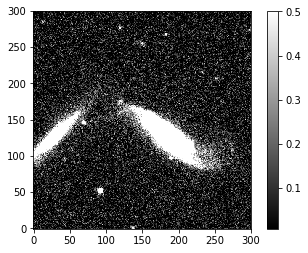

In [2]:
from matplotlib import pyplot as plt

primary_hdu = hdu_list[0]
header = primary_hdu.header
data = primary_hdu.data

print("These are the first 10 entries in the header:\n")
print(repr(header[:10]))

# You can access each entry in the header individually.
print("\nThe value of 'BITPIX' from the header is:", header['BITPIX'])

# Try playing around with the values for clim,
# or try deleting the argument all together
# Notice how it effects the displayed image
print("\nHere is a nice plot of the image:\n")
plt.imshow(primary_hdu.data, origin='lower', cmap='gray', clim=(0.008, 0.5))
plt.colorbar()
plt.show()

## Coordinates in an image <a class="anchor" id="coordinates-in-an-image"></a>

The position of objects in an astronomical image are typically represented in either pixel coordinates or in celestial coordinates. Converting between these unit systems requires knowing the World Coordinate System (WCS) for a particular image. This information is stored within the header of the FITS file itself, usually in terms of the following three values:

1. 'CRPIX' : The pixel coordinates of a reference pixel
1. 'CRVAL' : The the real world coordinates of the referance pixel
1. 'CD' : The increment in real world coordinates between pixels

The `astropy.coordinates.SkyCoord` module has a lot of useful tools for converting between various coordinate systems, but we won't talk about them all here. Instead we show a few short examples of how to specify coordinates. Notice that no matter how we specify the coordinates, `SkyCoord` internally stores the coordinates in units of degrees.

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

hdu_list = fits.open("sn2007cm.fits")
primary_hdu = hdu_list[0]

# This retrieves the WCS information from the image
image_wcs = WCS(primary_hdu)

# Create a coordinate object from units of degrees
coord_from_degrees = SkyCoord(190.6875, 55.1492, unit=('deg'))
print('A SkyCord object created with inputs ra = 190.6875 deg, dec = 55.1492 deg :')
print(coord_from_degrees, '\n')

# Create a coordinate in celestial units
coord_from_hourangle = SkyCoord("12:42:45.18", "+3:40:35.8", unit=u.hourangle)
print('A SkyCord object created with hourangle inputs',
      'ra = 12:42:45.18, dec = +3:40:35.8 :')
print(coord_from_hourangle, '\n')

# Create a coordinate object from pixel values
# Notice that this time we have to use `.from_pixel`
coord_from_pixel = SkyCoord.from_pixel(149.75, 150.31, image_wcs)
print('A SkyCord object created with pixel coordinates ra = 149.75 px, dec = 150.31 px :')
print(coord_from_pixel, '\n')

# We can also convert the coordinates back to pixel values
print('The pixel coordinates corresponding to',
      '(approximatly) ra = 190.69 deg, dec = 55.15 deg :')
print(coord_from_pixel.to_pixel(image_wcs))


A SkyCord object created with inputs ra = 190.6875 deg, dec = 55.1492 deg :
<SkyCoord (ICRS): (ra, dec) in deg
    ( 190.6875,  55.1492)> 

A SkyCord object created with hourangle inputs ra = 12:42:45.18, dec = +3:40:35.8 :
<SkyCoord (ICRS): (ra, dec) in deg
    ( 190.68825,  55.14916667)> 

A SkyCord object created with pixel coordinates ra = 149.75 px, dec = 150.31 px :
<SkyCoord (ICRS): (ra, dec) in deg
    ( 190.68750085,  55.14920023)> 

The pixel coordinates corresponding to (approximatly) ra = 190.69 deg, dec = 55.15 deg :
(array(149.7500000000304), array(150.3100000000054))


Typically, the coordinates of the object you're interested in will have to be read in from another file (even though they are "hard coded" in the example above, this is considered bad programming practice). One of the attractive features of SkyCord is that it can handle a wide range of input units depending on what the format of your input file is.

## Performing Photometry <a class="anchor" id="performing-photometry"></a>


The `photutils` package provides a few different aperture shapes (circle, oval, rectangular, annulus, etc.). We will be using the circular shaped aperture. For convenience, all of the `photutils` apertures come in pairs - one for pixel coordinates, and one for sky coordinates. For example, if you want a circular aperture in pixel coordinates, you would use the `CircularAperture` object. If you were working in sky coordinates, you would use the `SkyCircularAperture` object. 

Once I have selected my aperature, I can use the `aperture_photometry` function to perfrom apererture photometry. As an example, lets perform photometry on the bright star in the lower left corner of the example image using an aperature with a 10 arcsecond radius.

For reference, here is what the aperture looks like when drawn on the image (understanding the code in this cell is not important):


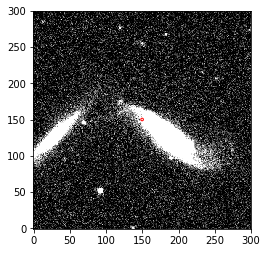

In [4]:
import astropy
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import numpy as np
from photutils import SkyCircularAperture
from astropy.coordinates import SkyCoord

# Get the world coordinate system
hdu_list = fits.open("sn2007cm.fits")
primary_hdu = hdu_list[0]
wcs = astropy.wcs.WCS(primary_hdu)

# Create an aperture at the location of sn2007cm
coord = SkyCoord(190.6875, 55.1492, unit=('deg'))
radius = 1 * astropy.units.arcsec
aperture = SkyCircularAperture(coord, radius)

# Create a circle to put on the image
pixel_cord = coord.to_pixel(wcs)
pixel_radius = np.sqrt(aperture.to_pixel(wcs).area() / np.pi)
circ = Circle(pixel_cord, radius=pixel_radius,
              facecolor='None', edgecolor='r', lw=1)

fig,ax = plt.subplots(1)
ax.imshow(primary_hdu.data, origin='lower', cmap='gray', clim=(0.008, 0.5))
ax.add_patch(circ)
plt.show()


Before performing aperture photometry, we need to look up some information on the the object we want to perform aperture photometry on. The following is some information for supernova 2007cm:

- The object is located at (190.6875, 55.1492) degrees
- The obect has a redshift of 0.016
- For the survey that took this image, 1 photon count is equal to 1.5 ergs / cm$^2$

This information tells us the location of the object in the image, how far away it is (we can calculate this from the redshift), and how to convert our results into units of energy. 

First lets determine the total photon counts within the aperture:

Once I have selected my aperature, I can use the `aperture_photometry` function to perfrom apererture photometry. As an example, lets perform photometry on the bright star in the lower left corner of the example image using an aperature with a 10 arcsecond radius.

In [6]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
from numpy import pi
from photutils import aperture_photometry, SkyCircularAperture

hdu_list = fits.open("sn2007cm.fits")
primary_hdu = hdu_list[0]

# The radius should be dimensionful
aperture_radius = 1 * u.arcsec

# We create an aperture using the coordinates and radius
aperture_coord = SkyCoord(190.6875, 55.1492, unit=('deg'))
aperture = SkyCircularAperture(aperture_coord, aperture_radius)

# We perfrom photometry. This will return results as a table
photometry_results = aperture_photometry(primary_hdu, aperture)
photometry_results

id,xcenter,ycenter,celestial_center,aperture_sum
,pix,pix,,
int64,float64,float64,object,float64
1,149.7531635455685,150.3084766212769,"<SkyCoord (ICRS): (ra, dec) in deg ( 190.6875, 55.1492)>",7.32764960559


We can now convert the sum of pixel values within the aperature to units of energy by using the conversion factor. We can access a column in the table by name, and a row by its index number. Note that the `id` number above is NOT the index number, since Python starts indices from 0.

In [7]:
# The conversion factor does not have to be dimensionful
# but doing so helps keep track of the units
conv_factor = 1.5 * u.erg / (u.s * u.cm * u.cm * u.AA)
photometry_energy = photometry_results['aperture_sum'][0] * conv_factor
print(photometry_energy)

10.991474408384605 erg / (Angstrom cm2 s)


The total energy output of the star is thus given by:

In [8]:
# This converts redshift to distance
redshift = 0.016
ldist = cosmo.luminosity_distance(redshift)

# We get the value of the distance in centimeters
ldist_cm = ldist.cgs

# We find the luminosity by multiplying by the total area
total_energy = photometry_energy * 4 * pi * (ldist_cm ** 2) 
print(total_energy)

6.45527649051932e+54 erg / (Angstrom s)


Notice that our final results are units of energy per wavelength per time.

For simplicity, here is the above code simplified into a single cell

In [10]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
from numpy import pi
from photutils import aperture_photometry, SkyCircularAperture

hdu_list = fits.open("sn2007cm.fits")
primary_hdu = hdu_list[0]

# Create the aperture
aperture_radius = 1 * u.arcsec
aperture_coord = SkyCoord(190.6875, 55.1492, unit=('deg'))
aperture = SkyCircularAperture(aperture_coord, aperture_radius)

# Perform aperture photometry
photometry_results = aperture_photometry(primary_hdu, aperture)
conv_factor = 1.5 * u.erg / (u.s * u.cm * u.cm * u.AA)
photometry_energy = photometry_results['aperture_sum'][0] * conv_factor

# Convert results to total energy
redshift = 0.016
ldist_cm = cosmo.luminosity_distance(redshift).cgs
total_energy = photometry_energy * 4 * pi * (ldist_cm ** 2) 
print(total_energy)


10.991474408384605 erg / (Angstrom cm2 s)
6.45527649051932e+54 erg / (Angstrom s)


## Bonus Code

In [ ]:
from astropy.nddata import Cutout2D

position = (4494.753, 2440.310)
size = (300, 300)     # pixels
cutout = Cutout2D(primary_hdu.data, position, size, wcs=WCS(primary_hdu))
plt.imshow(cutout.data, origin='lower', cmap='gray', clim=(0.008, 0.5))
plt.show()

hdu = fits.PrimaryHDU(cutout.data, header=cutout.wcs.to_header())
hdul = fits.HDUList([hdu])
hdul.writeto('sn2007cm.fits', overwrite=True)
